# 毕业论文`GRAD`
## 绘制网格范围图

---
*@author: Evan*\
*@date: 2024-03-14*

In [68]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader

from cnmaps import get_adm_maps, draw_map, draw_maps,clip_contours_by_map
from cnmaps.sample import load_dem

import cmaps
from matplotlib.colors import ListedColormap

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../src/')
from namelist import *

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [16]:
# Read and extract coordinates
def read_coordinates(wrf_file, cmaq_file):
    """
    Read GRID data from WRF and CMAQ, and extract lon and lat variables.
    """
    wrf_data = xr.open_dataset(wrf_file)
    cmaq_data = xr.open_dataset(cmaq_file)
    
    wrf_lon  = wrf_data['XLONG_M'].squeeze()
    wrf_lat  = wrf_data['XLAT_M'].squeeze()
    cmaq_lon = cmaq_data['LON'].squeeze()
    cmaq_lat = cmaq_data['LAT'].squeeze()

    return wrf_lon, wrf_lat, cmaq_lon, cmaq_lat

wrf_lon_d01, wrf_lat_d01, cmaq_lon_d01, cmaq_lat_d01 = read_coordinates(geo_d01, grid_d01)
wrf_lon_d02, wrf_lat_d02, cmaq_lon_d02, cmaq_lat_d02 = read_coordinates(geo_d02, grid_d02)
wrf_lon_d03, wrf_lat_d03, cmaq_lon_d03, cmaq_lat_d03 = read_coordinates(geo_d03, grid_d03)

In [57]:
# Extract boundary values
def extract_boundary(dataarray):
    """
    Extract boundary values from a 2D array.
    """
    top = dataarray[-1, :].values
    bottom = dataarray[0, :].values
    left = dataarray[:, 0].values
    right = dataarray[:, -1].values
    
    return top, bottom, left, right

# for WRF data
wrf_lon_top_d01, wrf_lon_bottom_d01, wrf_lon_left_d01, wrf_lon_right_d01 = extract_boundary(wrf_lon_d01)
wrf_lon_top_d02, wrf_lon_bottom_d02, wrf_lon_left_d02, wrf_lon_right_d02 = extract_boundary(wrf_lon_d02)
wrf_lon_top_d03, wrf_lon_bottom_d03, wrf_lon_left_d03, wrf_lon_right_d03 = extract_boundary(wrf_lon_d03)

wrf_lat_top_d01, wrf_lat_bottom_d01, wrf_lat_left_d01, wrf_lat_right_d01 = extract_boundary(wrf_lat_d01)
wrf_lat_top_d02, wrf_lat_bottom_d02, wrf_lat_left_d02, wrf_lat_right_d02 = extract_boundary(wrf_lat_d02)
wrf_lat_top_d03, wrf_lat_bottom_d03, wrf_lat_left_d03, wrf_lat_right_d03 = extract_boundary(wrf_lat_d03)

# for CMAQ data
cmaq_lon_top_d01, cmaq_lon_bottom_d01, cmaq_lon_left_d01, cmaq_lon_right_d01 = extract_boundary(cmaq_lon_d01)
cmaq_lon_top_d02, cmaq_lon_bottom_d02, cmaq_lon_left_d02, cmaq_lon_right_d02 = extract_boundary(cmaq_lon_d02)
cmaq_lon_top_d03, cmaq_lon_bottom_d03, cmaq_lon_left_d03, cmaq_lon_right_d03 = extract_boundary(cmaq_lon_d03)

cmaq_lat_top_d01, cmaq_lat_bottom_d01, cmaq_lat_left_d01, cmaq_lat_right_d01 = extract_boundary(cmaq_lat_d01)
cmaq_lat_top_d02, cmaq_lat_bottom_d02, cmaq_lat_left_d02, cmaq_lat_right_d02 = extract_boundary(cmaq_lat_d02)
cmaq_lat_top_d03, cmaq_lat_bottom_d03, cmaq_lat_left_d03, cmaq_lat_right_d03 = extract_boundary(cmaq_lat_d03)


wrf_lon_vars = []
wrf_lat_vars = []
cmaq_lon_vars = []
cmaq_lat_vars = []

for i in range(1, 4):
    wrf_lon_vars.extend([globals()[f'wrf_lon_top_d0{i}'], globals()[f'wrf_lon_bottom_d0{i}'], 
                         globals()[f'wrf_lon_left_d0{i}'], globals()[f'wrf_lon_right_d0{i}']])
    wrf_lat_vars.extend([globals()[f'wrf_lat_top_d0{i}'], globals()[f'wrf_lat_bottom_d0{i}'], 
                         globals()[f'wrf_lat_left_d0{i}'], globals()[f'wrf_lat_right_d0{i}']])
    cmaq_lon_vars.extend([globals()[f'cmaq_lon_top_d0{i}'], globals()[f'cmaq_lon_bottom_d0{i}'], 
                         globals()[f'cmaq_lon_left_d0{i}'], globals()[f'cmaq_lon_right_d0{i}']])
    cmaq_lat_vars.extend([globals()[f'cmaq_lat_top_d0{i}'], globals()[f'cmaq_lat_bottom_d0{i}'], 
                         globals()[f'cmaq_lat_left_d0{i}'], globals()[f'cmaq_lat_right_d0{i}']])


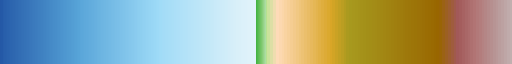

In [69]:
cmap1=cmaps.WhiteBlue_r
cmap2=cmaps.WhiteGreen_r
cmap3=cmaps.GMT_globe

list1=cmap1(np.linspace(0.2,0.85,1000))
list2=cmap2(np.linspace(0.5,0.8,40))
list3=cmap3(np.linspace(0.51,0.85,960))
ncolor=np.vstack((list1,list2,list3))
newmap=ListedColormap(ncolor)

newmap

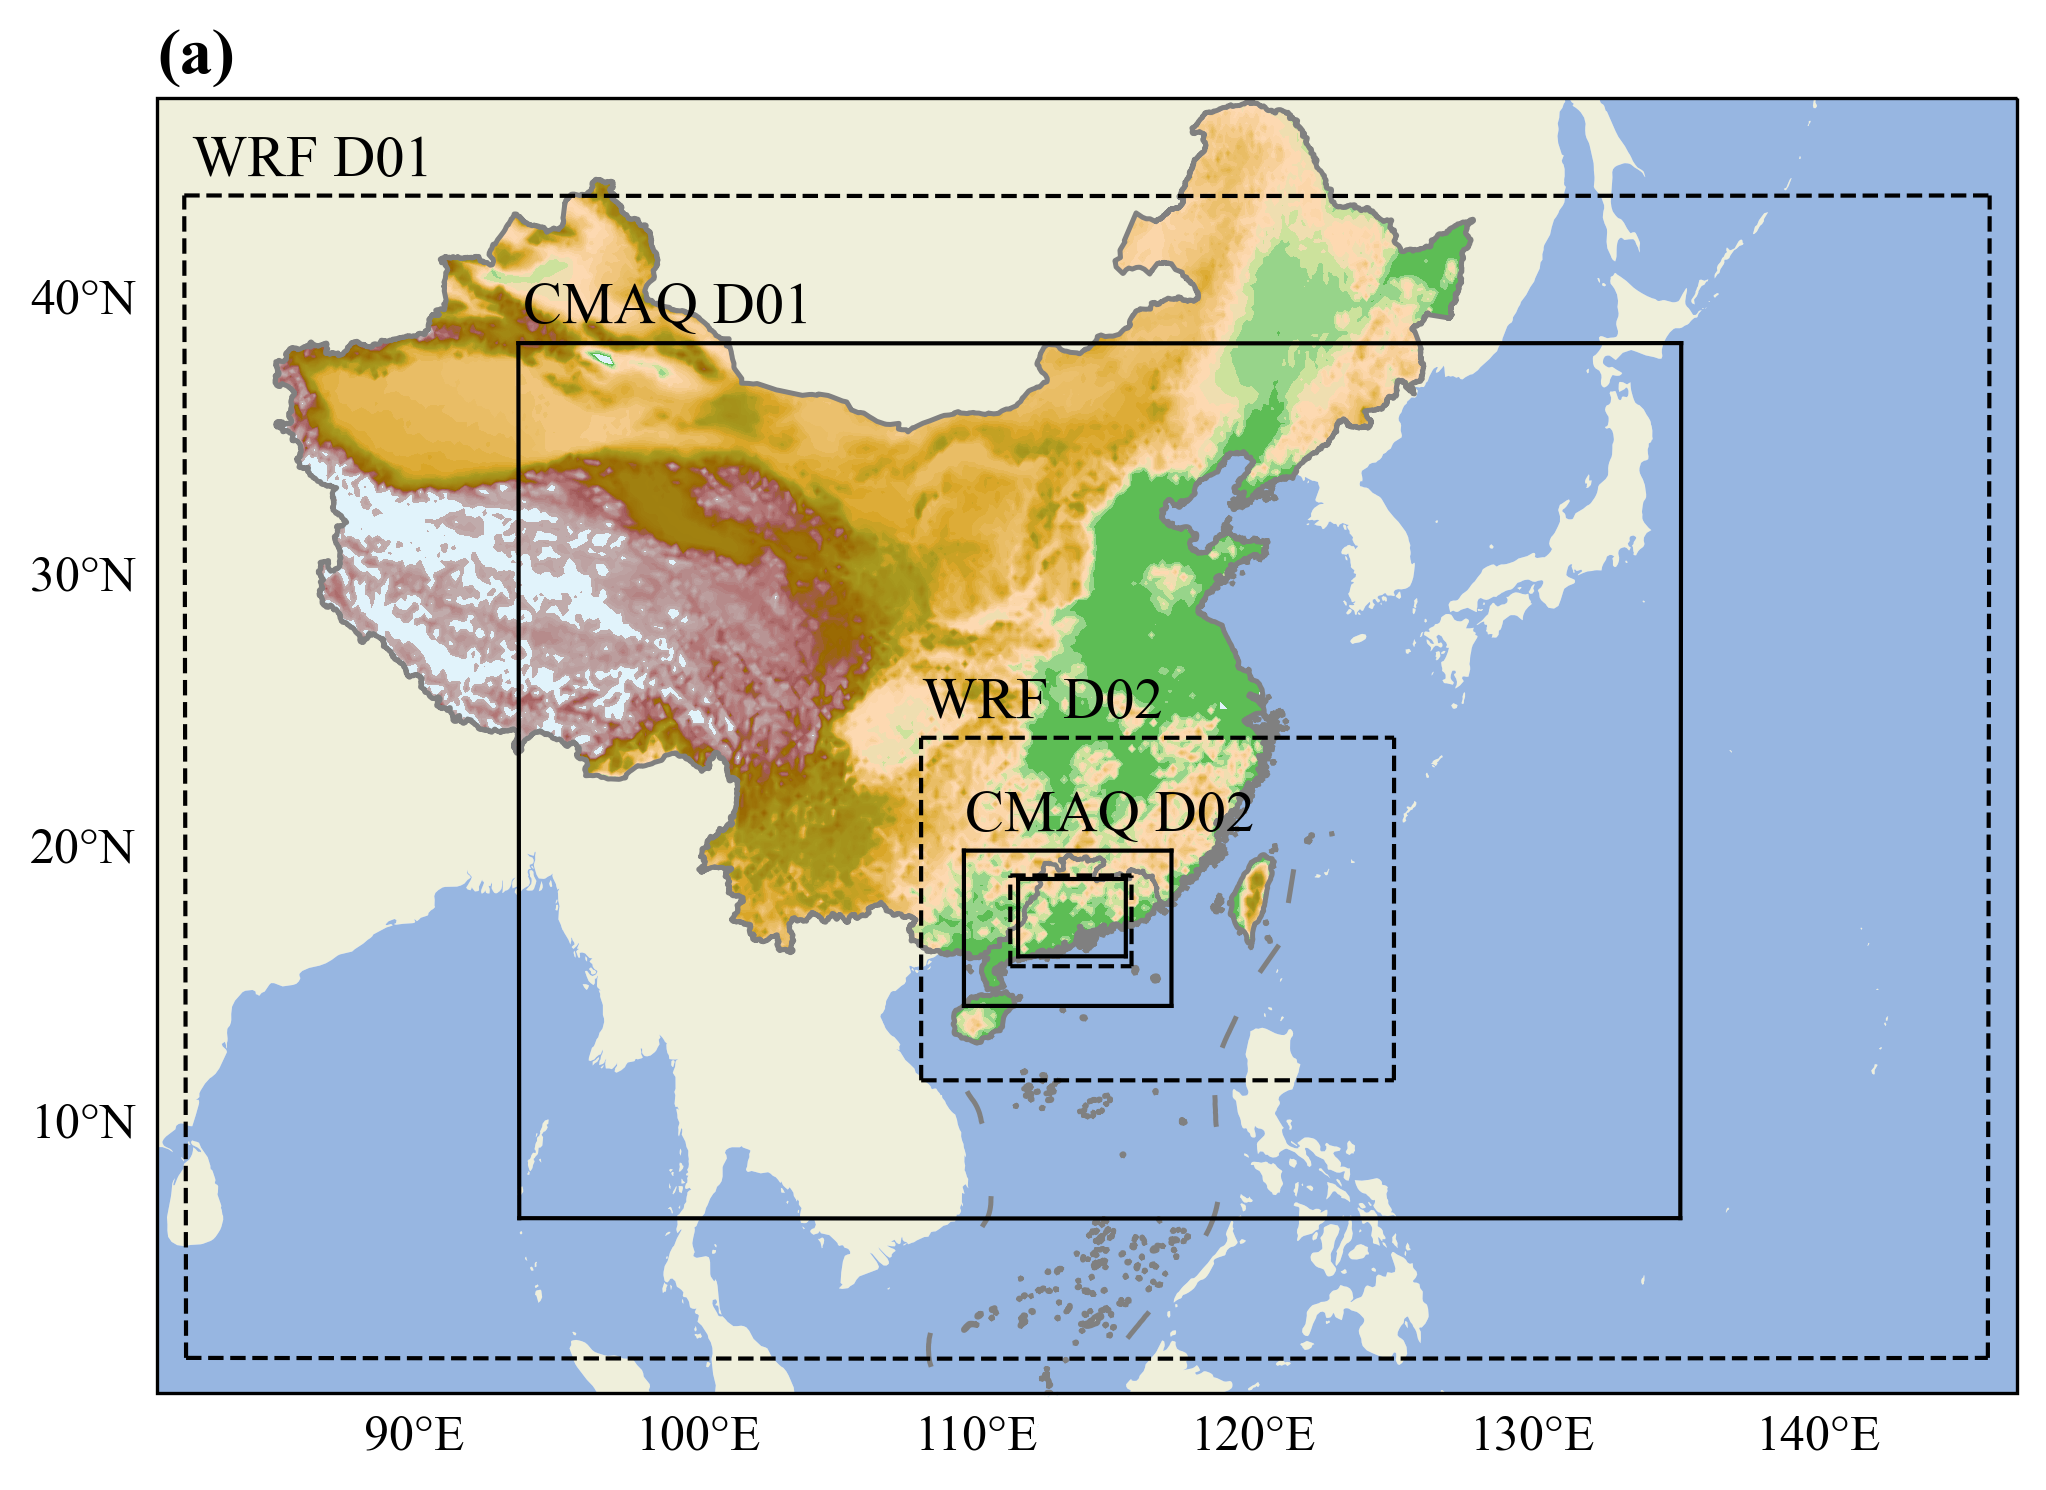

In [84]:
lons, lats, dem = load_dem()
proj=ccrs.LambertConformal(central_longitude=114,central_latitude=28.5,
                           standard_parallels=(15,40))
proj_shp=ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8),dpi=300)
ax = fig.subplots(1,1,subplot_kw={'projection':proj})

ax.set_extent([80, 148, 5, 51], crs=proj_shp)
ax.add_feature(cfeat.LAND.with_scale('50m'))
ax.add_feature(cfeat.OCEAN.with_scale('50m'))

labelsize=12
gl=ax.gridlines(
    xlocs=np.arange(-180, 180 + 1, 10), ylocs=np.arange(-90, 90 + 1, 10),
    draw_labels=True, x_inline=False, y_inline=False,
    linewidth=0, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels =False
gl.rotate_labels=False
gl.xlabel_style={'size':labelsize}
gl.ylabel_style={'size':labelsize}

# without NanHai Nine-Dash Line
# china = get_adm_maps(country='中华人民共和国', level='国',
#                       record='first', only_polygon=True)
# draw_map(china, color='gray', linewidth=1.2)

# with NanHai Nine-Dash Line
china = get_adm_maps(country='中华人民共和国', level='国',)
                    #   record='first', only_polygon=True)
draw_maps(china, color='gray', linewidth=1.2)
guangdong = get_adm_maps(province='广东省', level='省')
draw_maps(guangdong, color='gray', linewidth=1)

china = get_adm_maps(country='中华人民共和国', record='first', only_polygon=True)
cs = ax.contourf(lons, lats, dem, cmap=newmap,
                 levels=np.arange(-5000,5001,100), transform=proj_shp,)
clip_contours_by_map(cs, china)

# todo: add the boundary of the WRF and CMAQ data

wrfline = dict(linewidth=1, linestyle='--',color='k', transform=proj_shp)
cmaqline = dict(linewidth=1, linestyle='-',color='k', transform=proj_shp)

for wrf_lon, wrf_lat in zip(wrf_lon_vars, wrf_lat_vars):
    ax.plot(wrf_lon, wrf_lat, **wrfline)
for cmaq_lon, cmaq_lat in zip(cmaq_lon_vars, cmaq_lat_vars):
    ax.plot(cmaq_lon, cmaq_lat, **cmaqline)

# todo: add text to the boundary

textdict = dict(fontsize=14, color='k', transform=proj_shp)

ax.text(wrf_lon_top_d01[0],wrf_lat_top_d01[0]+0.8,'WRF D01',**textdict)
ax.text(wrf_lon_top_d02[0],wrf_lat_top_d02[0]+0.8,'WRF D02',**textdict)
# ax.text(wrf_lon_top_d03[0],wrf_lat_top_d03[0]+0.8,'WRF D03',**textdict)
ax.text(cmaq_lon_top_d01[0],cmaq_lat_top_d01[0]+0.8,'CMAQ D01',**textdict)
ax.text(cmaq_lon_top_d02[0],cmaq_lat_top_d02[0]+0.8,'CMAQ D02',**textdict)

ax.set_title('(a)',fontsize=16,fontweight='bold',loc='left')
plt.show()

In [119]:
GD = Reader('D:/data/Graduation/shapefile/ChinaAdminDivisonSHP-master/2. Province/province.shp')
GDC = Reader('D:/data/Graduation/shapefile/ChinaAdminDivisonSHP-master/3. City/city.shp')
PRD = Reader(shp_files['PRD_adm'])
MC = Reader(shp_files['Macau_adm'])
HK = Reader(shp_files['Hongkong_adm'])

In [92]:
# read station locations
met = pd.read_excel(datadir + 'OBS/stations/meteorology.xlsx',nrows=48,usecols=[2,3])
env = pd.read_excel(datadir + 'OBS/stations/environment.xlsx',usecols=[3,4])

met_lon = met.iloc[:,1].values
met_lat = met.iloc[:,0].values

env_lon = env.iloc[:,0].values
env_lat = env.iloc[:,1].values

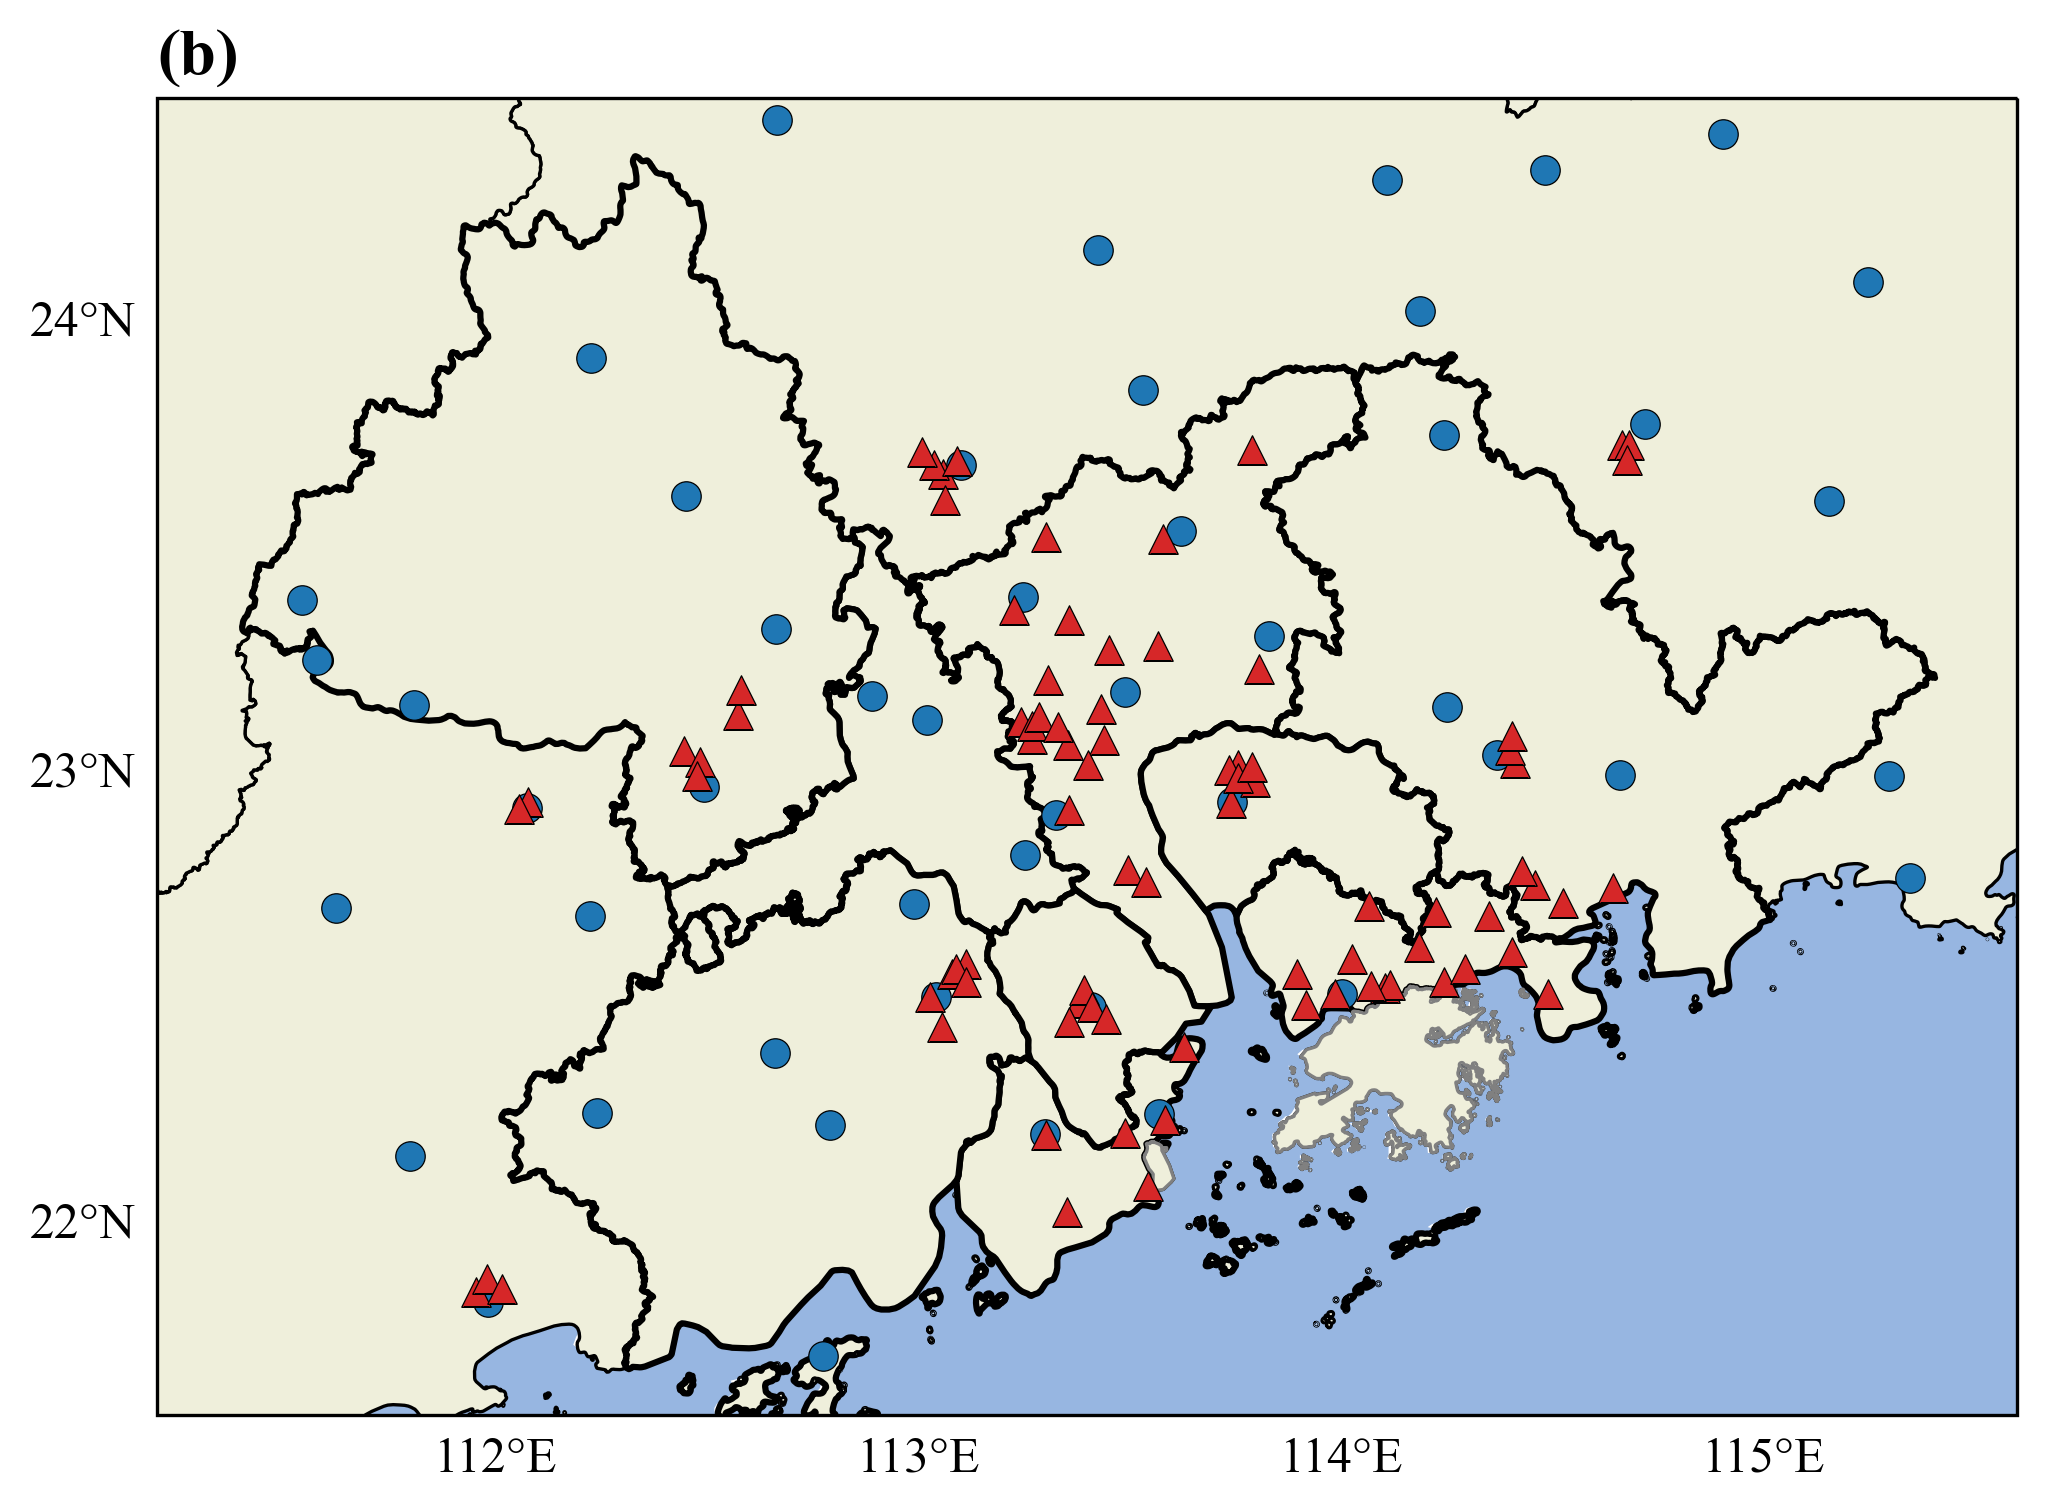

In [167]:
proj=ccrs.LambertConformal(central_longitude=114,central_latitude=28.5,
                           standard_parallels=(15,40))
proj_shp=ccrs.PlateCarree()

fig = plt.figure(figsize=(8,8),dpi=300)
ax = fig.subplots(1,1,subplot_kw={'projection':proj})

ax.set_extent([111.2, 115.6, 21.6, 24.5], crs=proj_shp)
# ax.add_feature(cfeat.LAND.with_scale('50m'))
ax.add_feature(cfeat.OCEAN.with_scale('10m'))
# ax.add_feature(cfeat.ShapelyFeature(GDC.geometries(),proj_shp,edgecolor='gray',facecolor='#efefdb'), linewidth=0.8)
ax.add_feature(cfeat.ShapelyFeature(GD.geometries(),proj_shp,edgecolor='k',facecolor='#efefdb'), linewidth=0.8)
ax.add_feature(cfeat.ShapelyFeature(PRD.geometries(),proj_shp,edgecolor='k',facecolor='#efefdb'), linewidth=1.5)
ax.add_feature(cfeat.ShapelyFeature(HK.geometries(),proj_shp,edgecolor='gray',facecolor='#efefdb'), linewidth=0.8)
ax.add_feature(cfeat.ShapelyFeature(MC.geometries(),proj_shp,edgecolor='gray',facecolor='#efefdb'), linewidth=0.8)

labelsize=12
gl=ax.gridlines(
    xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
    draw_labels=True, x_inline=False, y_inline=False,
    linewidth=0, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels =False
gl.rotate_labels=False
gl.xlabel_style={'size':labelsize}
gl.ylabel_style={'size':labelsize}

ax.scatter(met_lon,met_lat,transform=proj_shp,marker='o',s=50,c='tab:blue',
           edgecolors='k',linewidths=0.3,zorder=2)
ax.scatter(env_lon,env_lat,transform=proj_shp,marker='^',s=50,c='tab:red',
           edgecolors='k',linewidths=0.3,zorder=2)

ax.set_title('(b)',fontsize=16,fontweight='bold',loc='left')

plt.show()

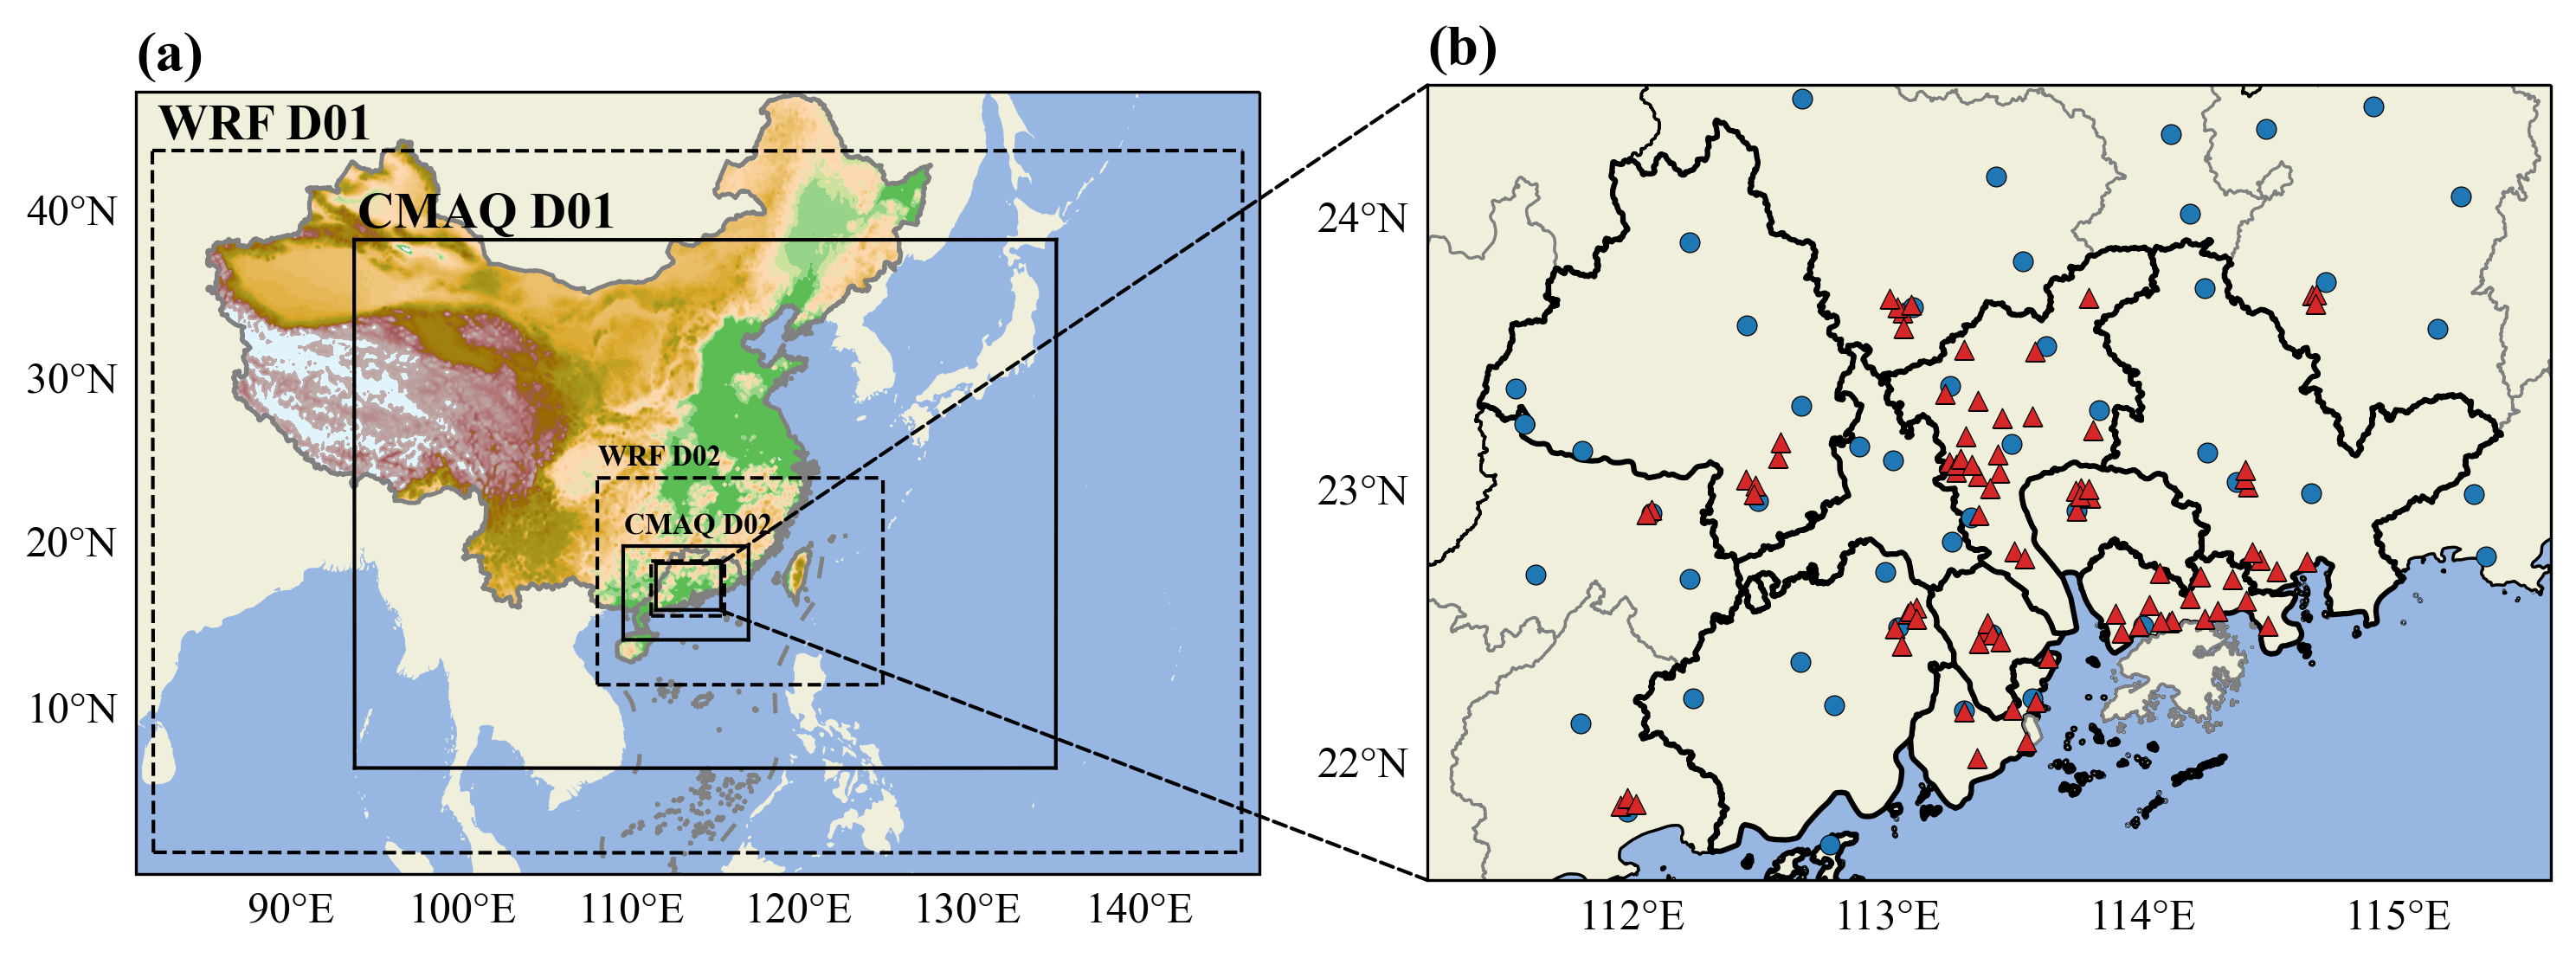

In [165]:
lons, lats, dem = load_dem()
proj=ccrs.LambertConformal(central_longitude=114,central_latitude=28.5,
                           standard_parallels=(15,40))
proj_shp=ccrs.PlateCarree()

fig = plt.figure(figsize=(12,6),dpi=300)
ax = fig.subplots(1,2,subplot_kw={'projection':proj})

ax[0].set_extent([80, 148, 5, 51], crs=proj_shp)
ax[0].add_feature(cfeat.LAND.with_scale('50m'))
ax[0].add_feature(cfeat.OCEAN.with_scale('50m'))

labelsize=12
gl=ax[0].gridlines(
    xlocs=np.arange(-180, 180 + 1, 10), ylocs=np.arange(-90, 90 + 1, 10),
    draw_labels=True, x_inline=False, y_inline=False,
    linewidth=0, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels =False
gl.rotate_labels=False
gl.xlabel_style={'size':labelsize}
gl.ylabel_style={'size':labelsize}

# with NanHai Nine-Dash Line
china = get_adm_maps(country='中华人民共和国', level='国',)
                    #   record='first', only_polygon=True)
draw_maps(china, color='gray', linewidth=1.2, ax=ax[0])
guangdong = get_adm_maps(province='广东省', level='省')
draw_maps(guangdong, color='gray', linewidth=1, ax=ax[0])

china = get_adm_maps(country='中华人民共和国', record='first', only_polygon=True)
cs = ax[0].contourf(lons, lats, dem, cmap=newmap,
                 levels=np.arange(-5000,5001,100), transform=proj_shp,)
clip_contours_by_map(cs, china, ax=ax[0])

# todo: add the boundary of the WRF and CMAQ data

wrfline = dict(linewidth=1, linestyle='--',color='k', transform=proj_shp)
cmaqline = dict(linewidth=1, linestyle='-',color='k', transform=proj_shp)

for wrf_lon, wrf_lat in zip(wrf_lon_vars, wrf_lat_vars):
    ax[0].plot(wrf_lon, wrf_lat, **wrfline)
for cmaq_lon, cmaq_lat in zip(cmaq_lon_vars, cmaq_lat_vars):
    ax[0].plot(cmaq_lon, cmaq_lat, **cmaqline)

# todo: add text to the boundary

textdict1 = dict(fontsize=14, fontweight='bold', color='k', transform=proj_shp)
textdict2 = dict(fontsize=8, fontweight='bold', color='k', transform=proj_shp)

ax[0].text(wrf_lon_top_d01[0],wrf_lat_top_d01[0]+0.8,'WRF D01',**textdict1)
ax[0].text(wrf_lon_top_d02[0],wrf_lat_top_d02[0]+0.8,'WRF D02',**textdict2)
ax[0].text(cmaq_lon_top_d01[0],cmaq_lat_top_d01[0]+0.8,'CMAQ D01',**textdict1)
ax[0].text(cmaq_lon_top_d02[0],cmaq_lat_top_d02[0]+0.8,'CMAQ D02',**textdict2)

ax[0].set_title('(a)',fontsize=16,fontweight='bold',loc='left')

# ===================================================================

ax[1].set_extent([111.2, 115.6, 21.6, 24.5], crs=proj_shp)
# ax[1].add_feature(cfeat.LAND.with_scale('50m'))
ax[1].add_feature(cfeat.OCEAN.with_scale('10m'))
ax[1].add_feature(cfeat.ShapelyFeature(GDC.geometries(),proj_shp,edgecolor='gray',facecolor='#efefdb'), linewidth=0.8)
ax[1].add_feature(cfeat.ShapelyFeature(GD.geometries(),proj_shp,edgecolor='k',facecolor='None'), linewidth=0.8)
ax[1].add_feature(cfeat.ShapelyFeature(PRD.geometries(),proj_shp,edgecolor='k',facecolor='#efefdb'), linewidth=1.5)
ax[1].add_feature(cfeat.ShapelyFeature(HK.geometries(),proj_shp,edgecolor='gray',facecolor='#efefdb'), linewidth=0.8)
ax[1].add_feature(cfeat.ShapelyFeature(MC.geometries(),proj_shp,edgecolor='gray',facecolor='#efefdb'), linewidth=0.8)

labelsize=12
gl=ax[1].gridlines(
    xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
    draw_labels=True, x_inline=False, y_inline=False,
    linewidth=0, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels =False
gl.rotate_labels=False
gl.xlabel_style={'size':labelsize}
gl.ylabel_style={'size':labelsize}

ax[1].scatter(met_lon,met_lat,transform=proj_shp,marker='o',s=30,c='tab:blue',
           edgecolors='k',linewidths=0.3,zorder=2)
ax[1].scatter(env_lon,env_lat,transform=proj_shp,marker='^',s=30,c='tab:red',
           edgecolors='k',linewidths=0.3,zorder=2)

ax[1].set_title('(b)',fontsize=16,fontweight='bold',loc='left')

# ===================================================================
from matplotlib.patches import ConnectionPatch

kw = dict(linestyle="--", color='k',zorder=3)
con1 = ConnectionPatch(xyA=(0.52, 0.337), coordsA=ax[0].transAxes,
                      xyB=(0, 0), coordsB=ax[1].transAxes,
                      axesA=ax[0], axesB=ax[1], **kw)
con2 = ConnectionPatch(xyA=(0.522, 0.398), coordsA=ax[0].transAxes,
                      xyB=(0, 1), coordsB=ax[1].transAxes,
                      axesA=ax[0], axesB=ax[1], **kw)
for con in (con1,con2):
    ax[0].add_artist(con)

plt.subplots_adjust(wspace=0.15)
plt.show()

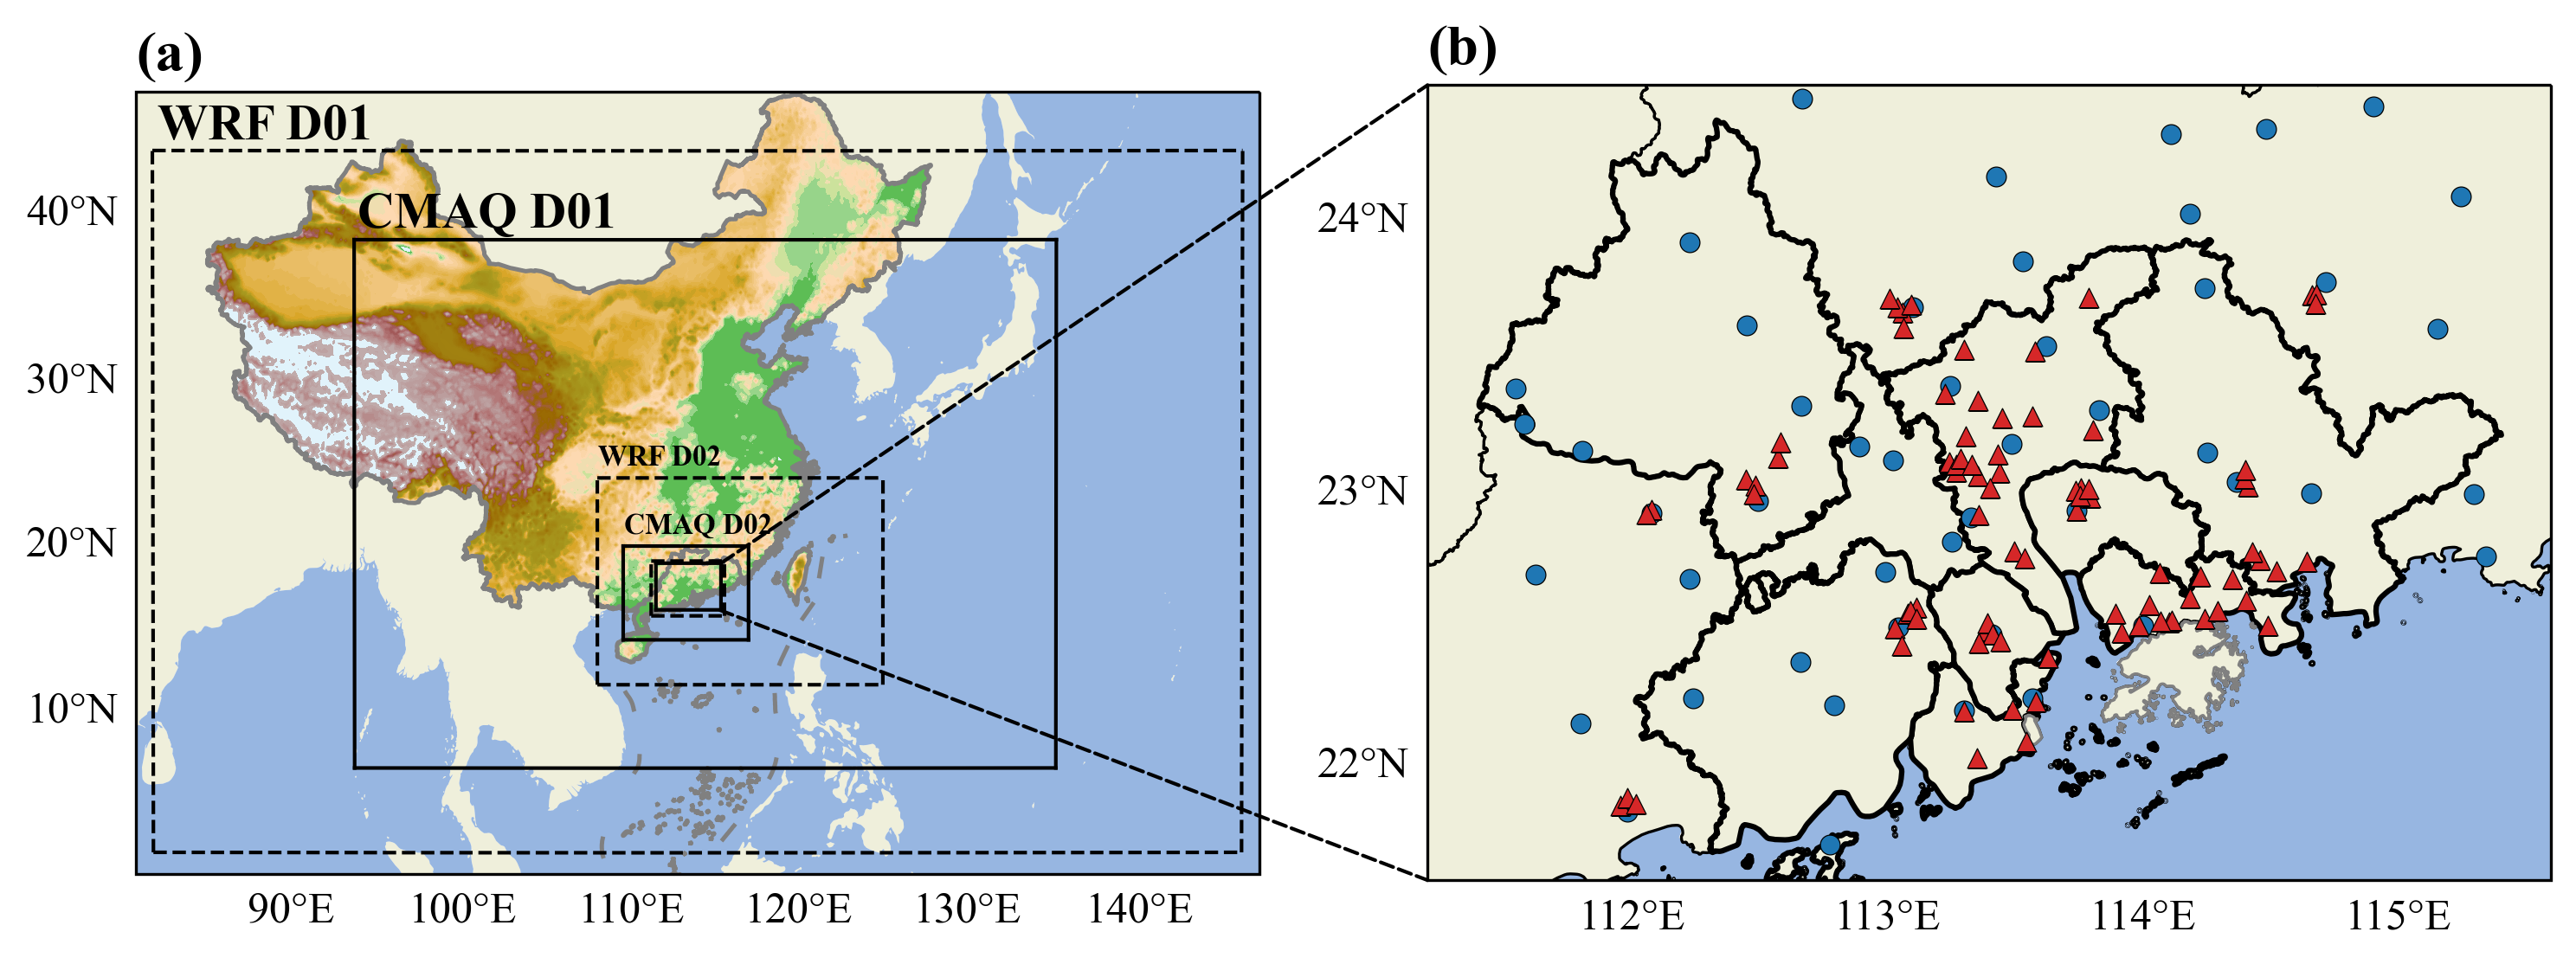

In [168]:
lons, lats, dem = load_dem()
proj=ccrs.LambertConformal(central_longitude=114,central_latitude=28.5,
                           standard_parallels=(15,40))
proj_shp=ccrs.PlateCarree()

fig = plt.figure(figsize=(12,6),dpi=300)
ax = fig.subplots(1,2,subplot_kw={'projection':proj})

ax[0].set_extent([80, 148, 5, 51], crs=proj_shp)
ax[0].add_feature(cfeat.LAND.with_scale('50m'))
ax[0].add_feature(cfeat.OCEAN.with_scale('50m'))

labelsize=12
gl=ax[0].gridlines(
    xlocs=np.arange(-180, 180 + 1, 10), ylocs=np.arange(-90, 90 + 1, 10),
    draw_labels=True, x_inline=False, y_inline=False,
    linewidth=0, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels =False
gl.rotate_labels=False
gl.xlabel_style={'size':labelsize}
gl.ylabel_style={'size':labelsize}

# with NanHai Nine-Dash Line
china = get_adm_maps(country='中华人民共和国', level='国',)
                    #   record='first', only_polygon=True)
draw_maps(china, color='gray', linewidth=1.2, ax=ax[0])
guangdong = get_adm_maps(province='广东省', level='省')
draw_maps(guangdong, color='gray', linewidth=1, ax=ax[0])

china = get_adm_maps(country='中华人民共和国', record='first', only_polygon=True)
cs = ax[0].contourf(lons, lats, dem, cmap=newmap,
                 levels=np.arange(-5000,5001,100), transform=proj_shp,)
clip_contours_by_map(cs, china, ax=ax[0])

# todo: add the boundary of the WRF and CMAQ data

wrfline = dict(linewidth=1, linestyle='--',color='k', transform=proj_shp)
cmaqline = dict(linewidth=1, linestyle='-',color='k', transform=proj_shp)

for wrf_lon, wrf_lat in zip(wrf_lon_vars, wrf_lat_vars):
    ax[0].plot(wrf_lon, wrf_lat, **wrfline)
for cmaq_lon, cmaq_lat in zip(cmaq_lon_vars, cmaq_lat_vars):
    ax[0].plot(cmaq_lon, cmaq_lat, **cmaqline)

# todo: add text to the boundary

textdict1 = dict(fontsize=14, fontweight='bold', color='k', transform=proj_shp)
textdict2 = dict(fontsize=8, fontweight='bold', color='k', transform=proj_shp)

ax[0].text(wrf_lon_top_d01[0],wrf_lat_top_d01[0]+0.8,'WRF D01',**textdict1)
ax[0].text(wrf_lon_top_d02[0],wrf_lat_top_d02[0]+0.8,'WRF D02',**textdict2)
ax[0].text(cmaq_lon_top_d01[0],cmaq_lat_top_d01[0]+0.8,'CMAQ D01',**textdict1)
ax[0].text(cmaq_lon_top_d02[0],cmaq_lat_top_d02[0]+0.8,'CMAQ D02',**textdict2)

ax[0].set_title('(a)',fontsize=16,fontweight='bold',loc='left')

# ===================================================================

ax[1].set_extent([111.2, 115.6, 21.6, 24.5], crs=proj_shp)
# ax[1].add_feature(cfeat.LAND.with_scale('50m'))
ax[1].add_feature(cfeat.OCEAN.with_scale('10m'))
# ax[1].add_feature(cfeat.ShapelyFeature(GDC.geometries(),proj_shp,edgecolor='gray',facecolor='#efefdb'), linewidth=0.8)
ax[1].add_feature(cfeat.ShapelyFeature(GD.geometries(),proj_shp,edgecolor='k',facecolor='#efefdb'), linewidth=0.8)
ax[1].add_feature(cfeat.ShapelyFeature(PRD.geometries(),proj_shp,edgecolor='k',facecolor='#efefdb'), linewidth=1.5)
ax[1].add_feature(cfeat.ShapelyFeature(HK.geometries(),proj_shp,edgecolor='gray',facecolor='#efefdb'), linewidth=0.8)
ax[1].add_feature(cfeat.ShapelyFeature(MC.geometries(),proj_shp,edgecolor='gray',facecolor='#efefdb'), linewidth=0.8)

labelsize=12
gl=ax[1].gridlines(
    xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
    draw_labels=True, x_inline=False, y_inline=False,
    linewidth=0, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels =False
gl.rotate_labels=False
gl.xlabel_style={'size':labelsize}
gl.ylabel_style={'size':labelsize}

ax[1].scatter(met_lon,met_lat,transform=proj_shp,marker='o',s=30,c='tab:blue',
           edgecolors='k',linewidths=0.3,zorder=2)
ax[1].scatter(env_lon,env_lat,transform=proj_shp,marker='^',s=30,c='tab:red',
           edgecolors='k',linewidths=0.3,zorder=2)

ax[1].set_title('(b)',fontsize=16,fontweight='bold',loc='left')

# ===================================================================
from matplotlib.patches import ConnectionPatch

kw = dict(linestyle="--", color='k',zorder=3)
con1 = ConnectionPatch(xyA=(0.52, 0.337), coordsA=ax[0].transAxes,
                      xyB=(0, 0), coordsB=ax[1].transAxes,
                      axesA=ax[0], axesB=ax[1], **kw)
con2 = ConnectionPatch(xyA=(0.522, 0.398), coordsA=ax[0].transAxes,
                      xyB=(0, 1), coordsB=ax[1].transAxes,
                      axesA=ax[0], axesB=ax[1], **kw)
for con in (con1,con2):
    ax[0].add_artist(con)

plt.subplots_adjust(wspace=0.15)
plt.show()